In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
import json

import tensorflow as tf
tf.config.run_functions_eagerly(True)

from datetime import datetime


!nvidia-smi

Mon Mar 15 11:54:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
project_dir="/content/drive/MyDrive/comp598-II/project"

src_dir=os.path.join(project_dir,"src")
datadir=os.path.join(project_dir,"data/")
npy_dir=os.path.join(project_dir,"data/npy")
result_dir=os.path.join(project_dir,"notebooks/DANN-WISDM/experiments")

import sys
sys.path.append(src_dir)

import dann_v1 as dann

In [3]:
#@title Default title text
unseen_subj =  1610#@param {type:"integer"}


In [4]:
seen_subj = list(range(1600,1605))

In [5]:
save_dir=str(seen_subj[0])+"-"
for s in seen_subj[1:]:
  save_dir+=(str(s)[2:]+"-")

save_dir+=("to-{}".format(unseen_subj))
save_dir=os.path.join(result_dir,save_dir)

try:  
    os.mkdir(save_dir)  
except OSError as error:  
    print(error) 

[Errno 17] File exists: '/content/drive/MyDrive/comp598-II/project/notebooks/DANN-WISDM/experiments/1600-01-02-03-04-to-1610'


In [6]:
summary={}

alpha=0.75
batchsize=32
EPOCHS=90
indomain_epoch=20
cv=5

clf_lr= 1e-4
disc_lr=1e-4
ext_lr= 1e-4

act_subset=['Walking',
            'Clapping',
            'Drinking from Cup',
            'Jogging',
            'Brushing Teeth',
            'Typing',
            'Writing',
            'Stairs']

seen_device, unseen_device = "watch", "watch"
seen_sensor, unseen_sensor = "accel", "accel"


with open(os.path.join(datadir,"act_to_int.json"),"r") as jpath:
  act_int_lookup=json.load(jpath)

int_act_lookup={act_int_lookup[key]:key for key in act_int_lookup}

(seen_x,seen_y),(unseen_x,unseen_y),num_class, remapping_dict = dann.load_subjects(npy_dir,
                                                                   seen_subj,
                                                                   seen_device,
                                                                   seen_sensor,
                                                                   unseen_subj,
                                                                   unseen_device,
                                                                   unseen_sensor,
                                                                   act_int_lookup,
                                                                   act_subset)

remapped_int_act_lookup={remapping_dict[key]:int_act_lookup[int(remapping_dict[key])] for key in remapping_dict}
print(remapped_int_act_lookup)

print(seen_x.shape,seen_y.shape)
print(unseen_x.shape,unseen_y.shape)

{0: 'Walking', 1: 'Jogging', 2: 'Stairs', 3: 'Sitting', 4: 'Standing', 5: 'Typing', 6: 'Brushing Teeth', 7: 'Eating Soup'}
(2840, 100, 3) (2840,)
(568, 100, 3) (568,)


In [7]:
summary['alpha']=alpha
summary['batchsize']=batchsize
summary['crossdomain epoch']=EPOCHS
summary['indomain epoch']=indomain_epoch

summary['clf lr']=clf_lr
summary['disc lr']=disc_lr
summary['ext lr']=ext_lr
summary['act']=remapped_int_act_lookup

summary['source subj']=seen_subj
summary['source device']=seen_device
summary['source sensor']=seen_sensor
summary['source data shape']=seen_x.shape
summary['source class dist']=dann.label_breakdown(seen_y)

summary['target subj']=unseen_subj
summary['target device']=unseen_device
summary['target sensor']=unseen_sensor
summary['target data shape']=unseen_x.shape
summary['target class dist']=dann.label_breakdown(unseen_y)

In [8]:
summary

{'act': {0: 'Walking',
  1: 'Jogging',
  2: 'Stairs',
  3: 'Sitting',
  4: 'Standing',
  5: 'Typing',
  6: 'Brushing Teeth',
  7: 'Eating Soup'},
 'alpha': 0.75,
 'batchsize': 32,
 'clf lr': 0.0001,
 'crossdomain epoch': 90,
 'disc lr': 0.0001,
 'ext lr': 0.0001,
 'indomain epoch': 20,
 'source class dist': {0: 355,
  1: 355,
  2: 355,
  3: 355,
  4: 355,
  5: 355,
  6: 355,
  7: 355},
 'source data shape': (2840, 100, 3),
 'source device': 'watch',
 'source sensor': 'accel',
 'source subj': [1600, 1601, 1602, 1603, 1604],
 'target class dist': {0: 71, 1: 71, 2: 71, 3: 71, 4: 71, 5: 71, 6: 71, 7: 71},
 'target data shape': (568, 100, 3),
 'target device': 'watch',
 'target sensor': 'accel',
 'target subj': 1610}

epoch 1/90
18/18 [==============================] - 35s 107ms/batch - classifier acc: 0.4539 - classifier loss: 1.4994 - domain acc: 0.4944 - domain_loss: 0.5500
epoch 2/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.6414 - classifier loss: 0.8216 - domain acc: 0.4810 - domain_loss: 0.5954
epoch 3/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7401 - classifier loss: 0.5636 - domain acc: 0.4917 - domain_loss: 0.5699
epoch 4/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7368 - classifier loss: 0.5999 - domain acc: 0.6029 - domain_loss: 0.4981
epoch 5/90
18/18 [==============================] - 1s 73ms/batch - classifier acc: 0.7500 - classifier loss: 0.5355 - domain acc: 0.5107 - domain_loss: 0.5421
epoch 6/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7763 - classifier loss: 0.4794 - domain acc: 0.4958 - domain_loss: 0.5601
epoch 7/90
18/18 [====================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


============================ cv 1/5 ==========================
1.0
0.9190140845070423
0.5741392801251957
/content/drive/MyDrive/comp598-II/project/notebooks/DANN-WISDM/experiments/1600-01-02-03-04-to-1610/crossdomain-1_5.jpg
epoch 1/90
18/18 [==============================] - 2s 76ms/batch - classifier acc: 0.4309 - classifier loss: 1.3804 - domain acc: 0.4584 - domain_loss: 0.5518
epoch 2/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.6020 - classifier loss: 0.9788 - domain acc: 0.5465 - domain_loss: 0.5551
epoch 3/90
18/18 [==============================] - 1s 73ms/batch - classifier acc: 0.6924 - classifier loss: 0.7560 - domain acc: 0.4920 - domain_loss: 0.5838
epoch 4/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7089 - classifier loss: 0.6433 - domain acc: 0.5795 - domain_loss: 0.5223
epoch 5/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7615 - classifier loss: 0.5587 - domain acc: 0.59

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


============================ cv 2/5 ==========================
0.9964788732394366
0.8838028169014085
0.452660406885759
/content/drive/MyDrive/comp598-II/project/notebooks/DANN-WISDM/experiments/1600-01-02-03-04-to-1610/crossdomain-2_5.jpg
epoch 1/90
18/18 [==============================] - 2s 76ms/batch - classifier acc: 0.4951 - classifier loss: 1.3710 - domain acc: 0.5159 - domain_loss: 0.5485
epoch 2/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.6332 - classifier loss: 0.8102 - domain acc: 0.4870 - domain_loss: 0.5719
epoch 3/90
18/18 [==============================] - 1s 73ms/batch - classifier acc: 0.7253 - classifier loss: 0.6629 - domain acc: 0.5625 - domain_loss: 0.5141
epoch 4/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7319 - classifier loss: 0.6061 - domain acc: 0.5492 - domain_loss: 0.5205
epoch 5/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7599 - classifier loss: 0.5419 - do

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


============================ cv 3/5 ==========================
0.9890845070422535
0.9348591549295775
0.4968701095461659
/content/drive/MyDrive/comp598-II/project/notebooks/DANN-WISDM/experiments/1600-01-02-03-04-to-1610/crossdomain-3_5.jpg
epoch 1/90
18/18 [==============================] - 2s 76ms/batch - classifier acc: 0.4276 - classifier loss: 1.4731 - domain acc: 0.5187 - domain_loss: 0.5428
epoch 2/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.5954 - classifier loss: 0.9377 - domain acc: 0.4505 - domain_loss: 0.5843
epoch 3/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.6382 - classifier loss: 0.8131 - domain acc: 0.5184 - domain_loss: 0.6004
epoch 4/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7204 - classifier loss: 0.6128 - domain acc: 0.5219 - domain_loss: 0.5524
epoch 5/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7812 - classifier loss: 0.4398 - d

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


============================ cv 4/5 ==========================
0.9855633802816901
0.8679577464788732
0.6474960876369327
/content/drive/MyDrive/comp598-II/project/notebooks/DANN-WISDM/experiments/1600-01-02-03-04-to-1610/crossdomain-4_5.jpg
epoch 1/90
18/18 [==============================] - 2s 76ms/batch - classifier acc: 0.3997 - classifier loss: 1.5566 - domain acc: 0.5035 - domain_loss: 0.5469
epoch 2/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.6776 - classifier loss: 0.7997 - domain acc: 0.5208 - domain_loss: 0.5498
epoch 3/90
18/18 [==============================] - 1s 73ms/batch - classifier acc: 0.6678 - classifier loss: 0.8125 - domain acc: 0.5463 - domain_loss: 0.6041
epoch 4/90
18/18 [==============================] - 1s 73ms/batch - classifier acc: 0.7039 - classifier loss: 0.6122 - domain acc: 0.5148 - domain_loss: 0.5520
epoch 5/90
18/18 [==============================] - 1s 72ms/batch - classifier acc: 0.7533 - classifier loss: 0.4773 - d

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


============================ cv 5/5 ==========================
0.9926056338028169
0.9454225352112676
0.46557120500782473
/content/drive/MyDrive/comp598-II/project/notebooks/DANN-WISDM/experiments/1600-01-02-03-04-to-1610/crossdomain-5_5.jpg


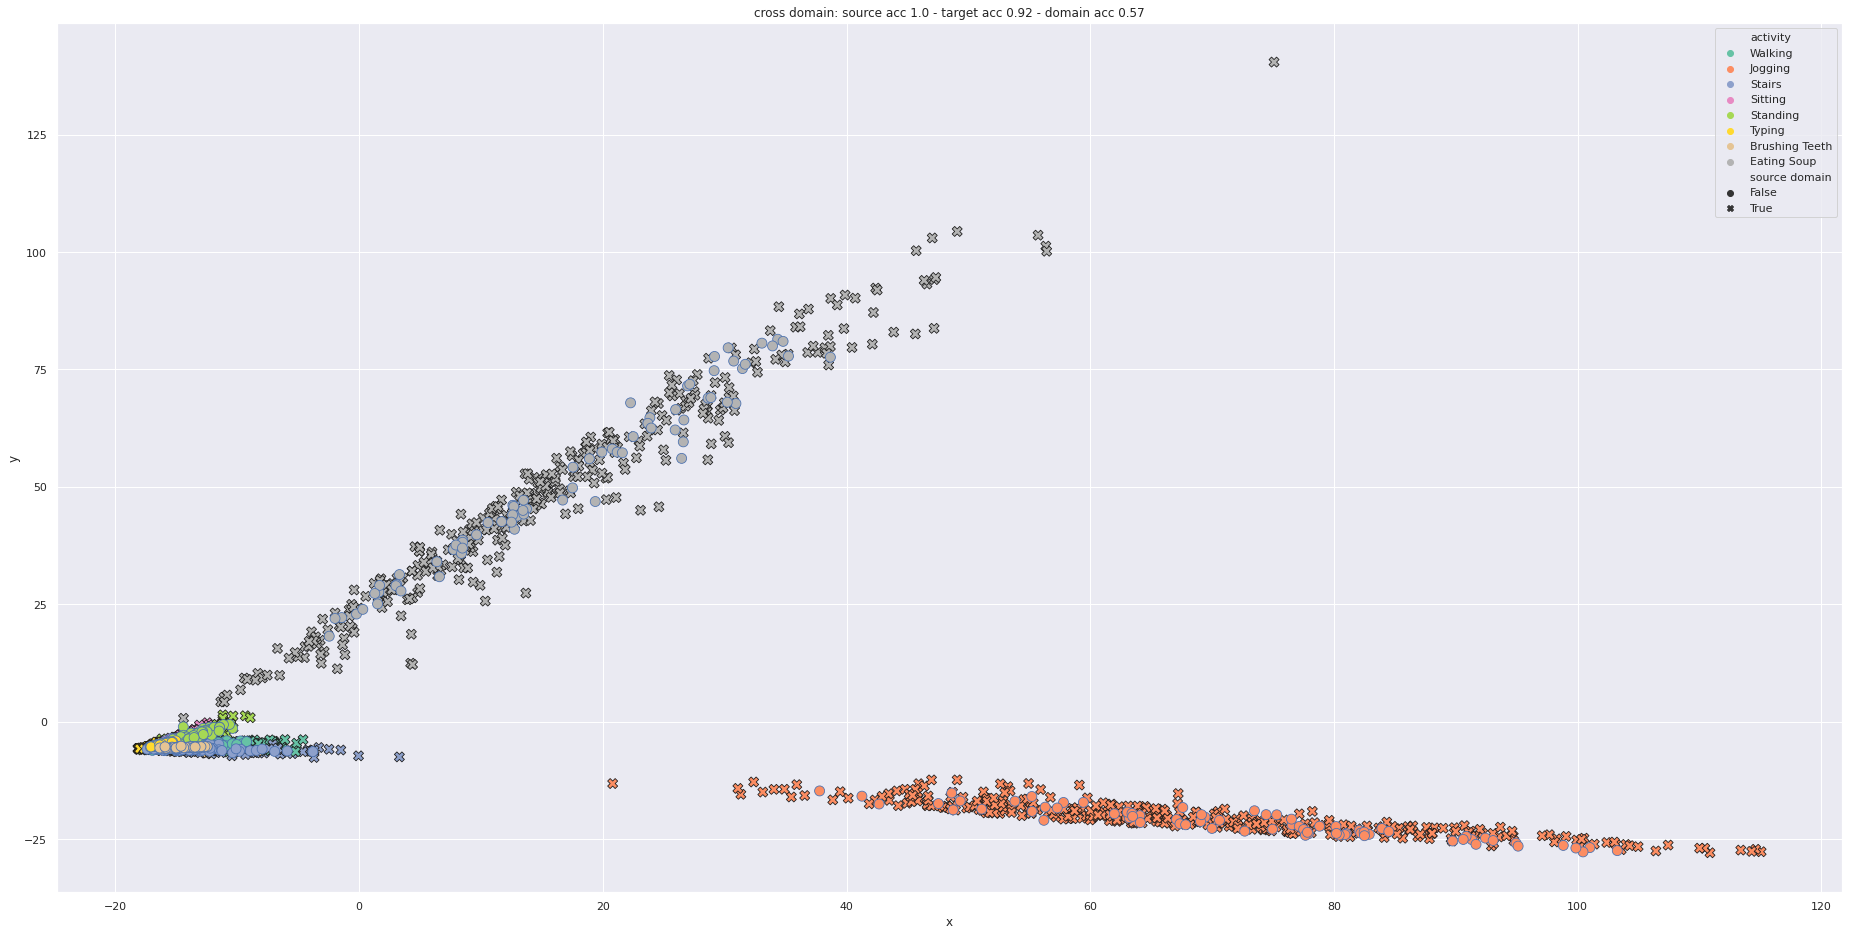

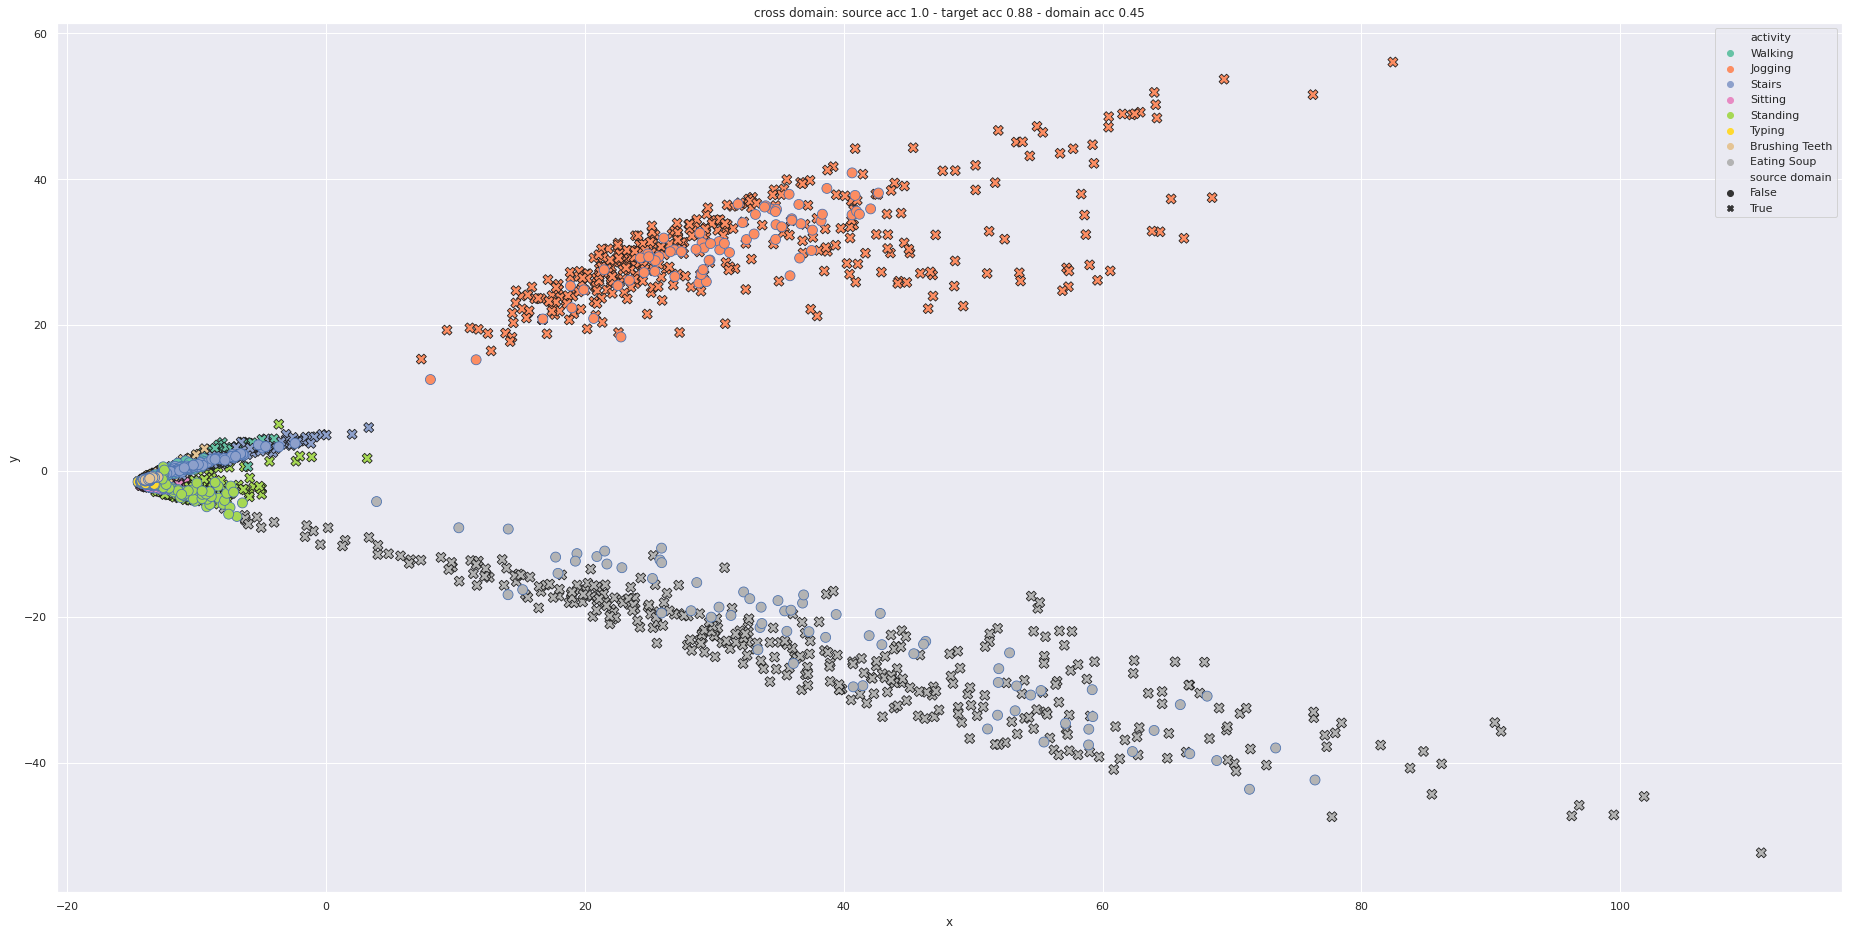

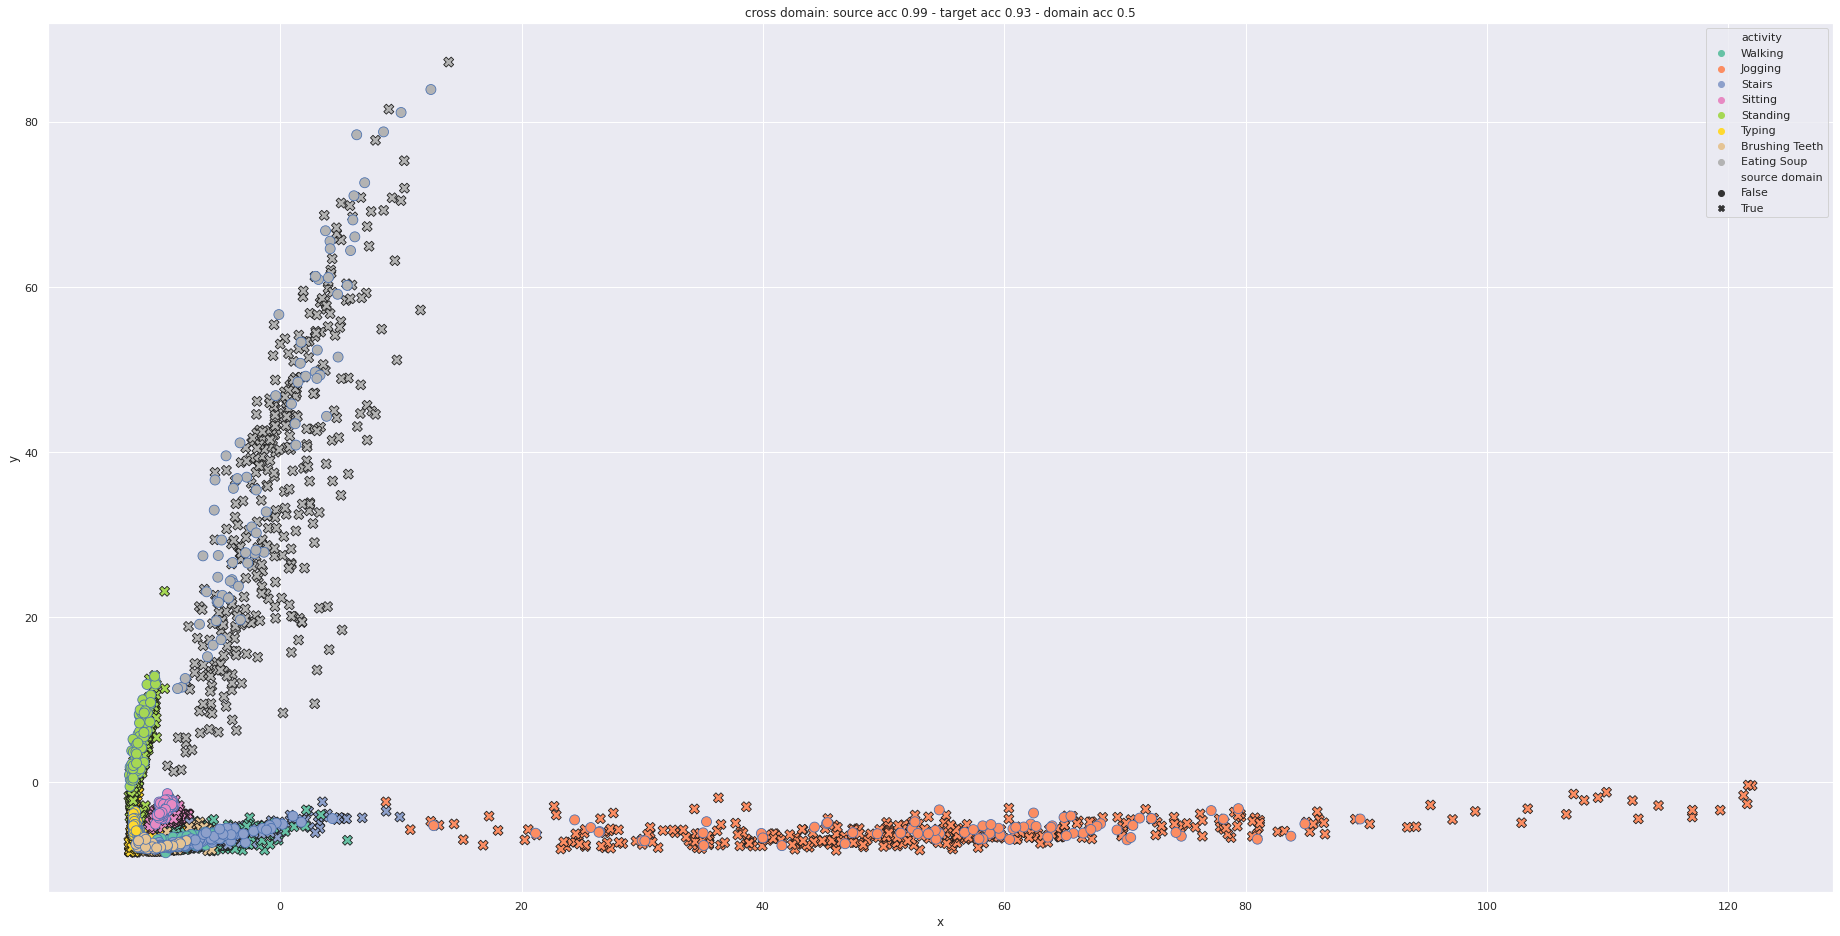

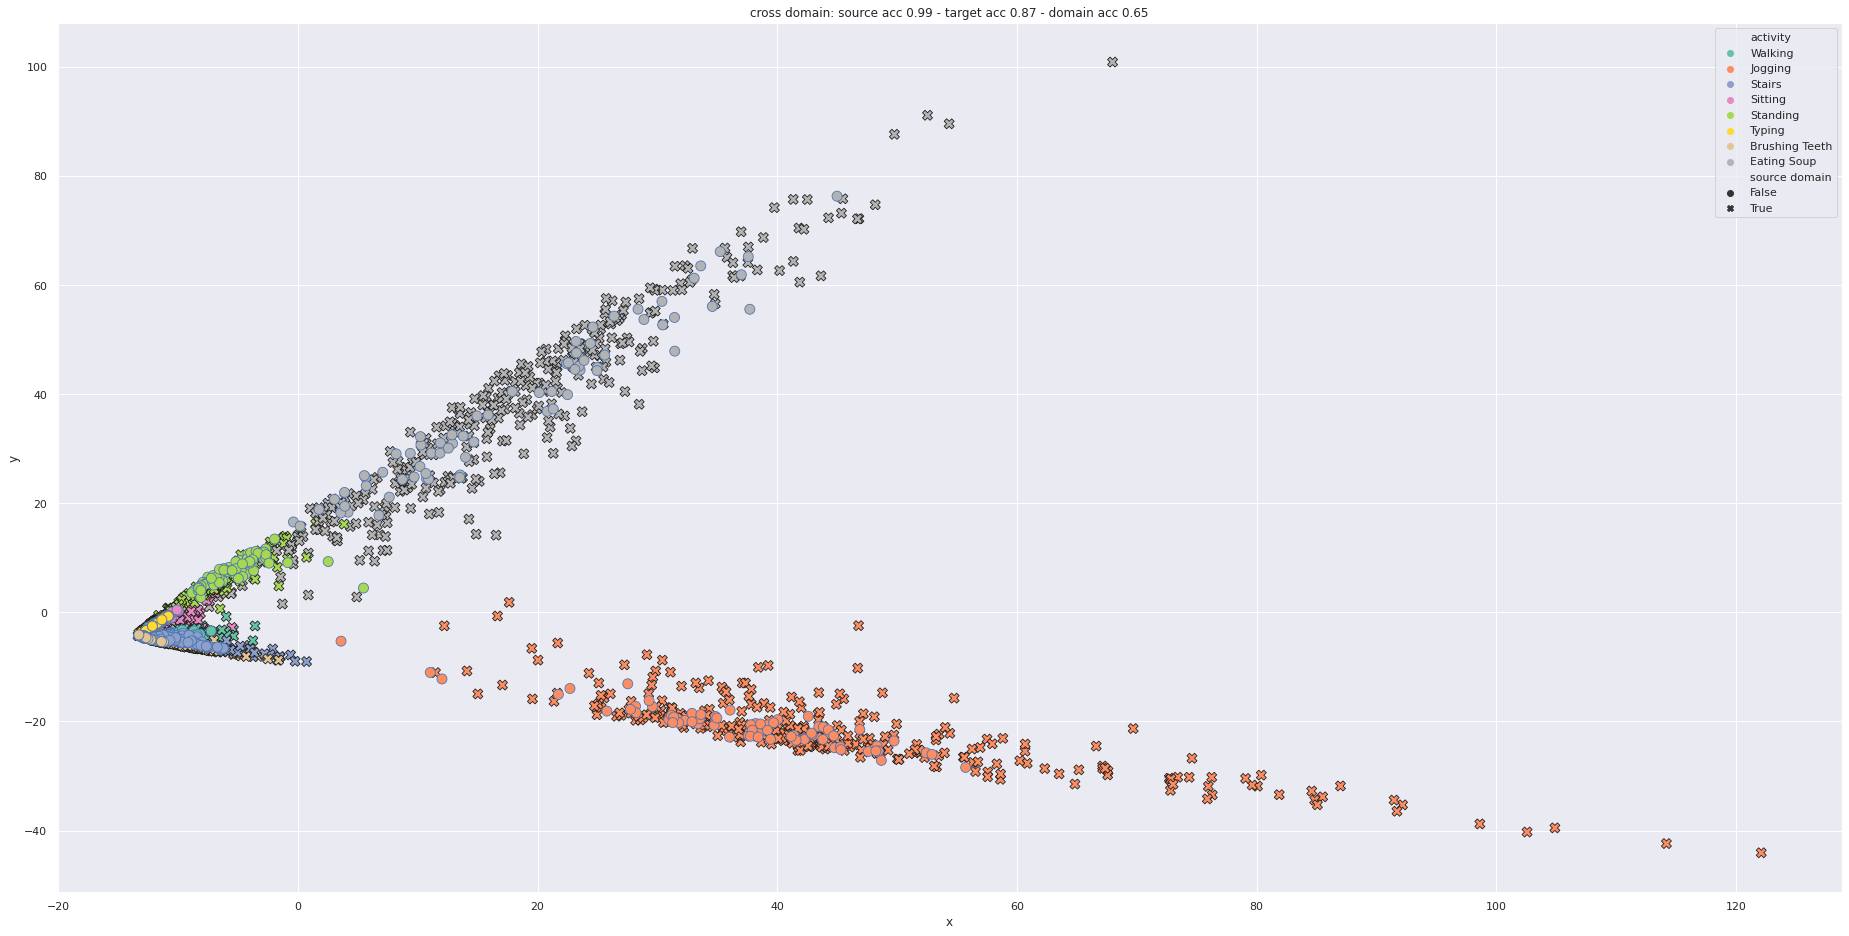

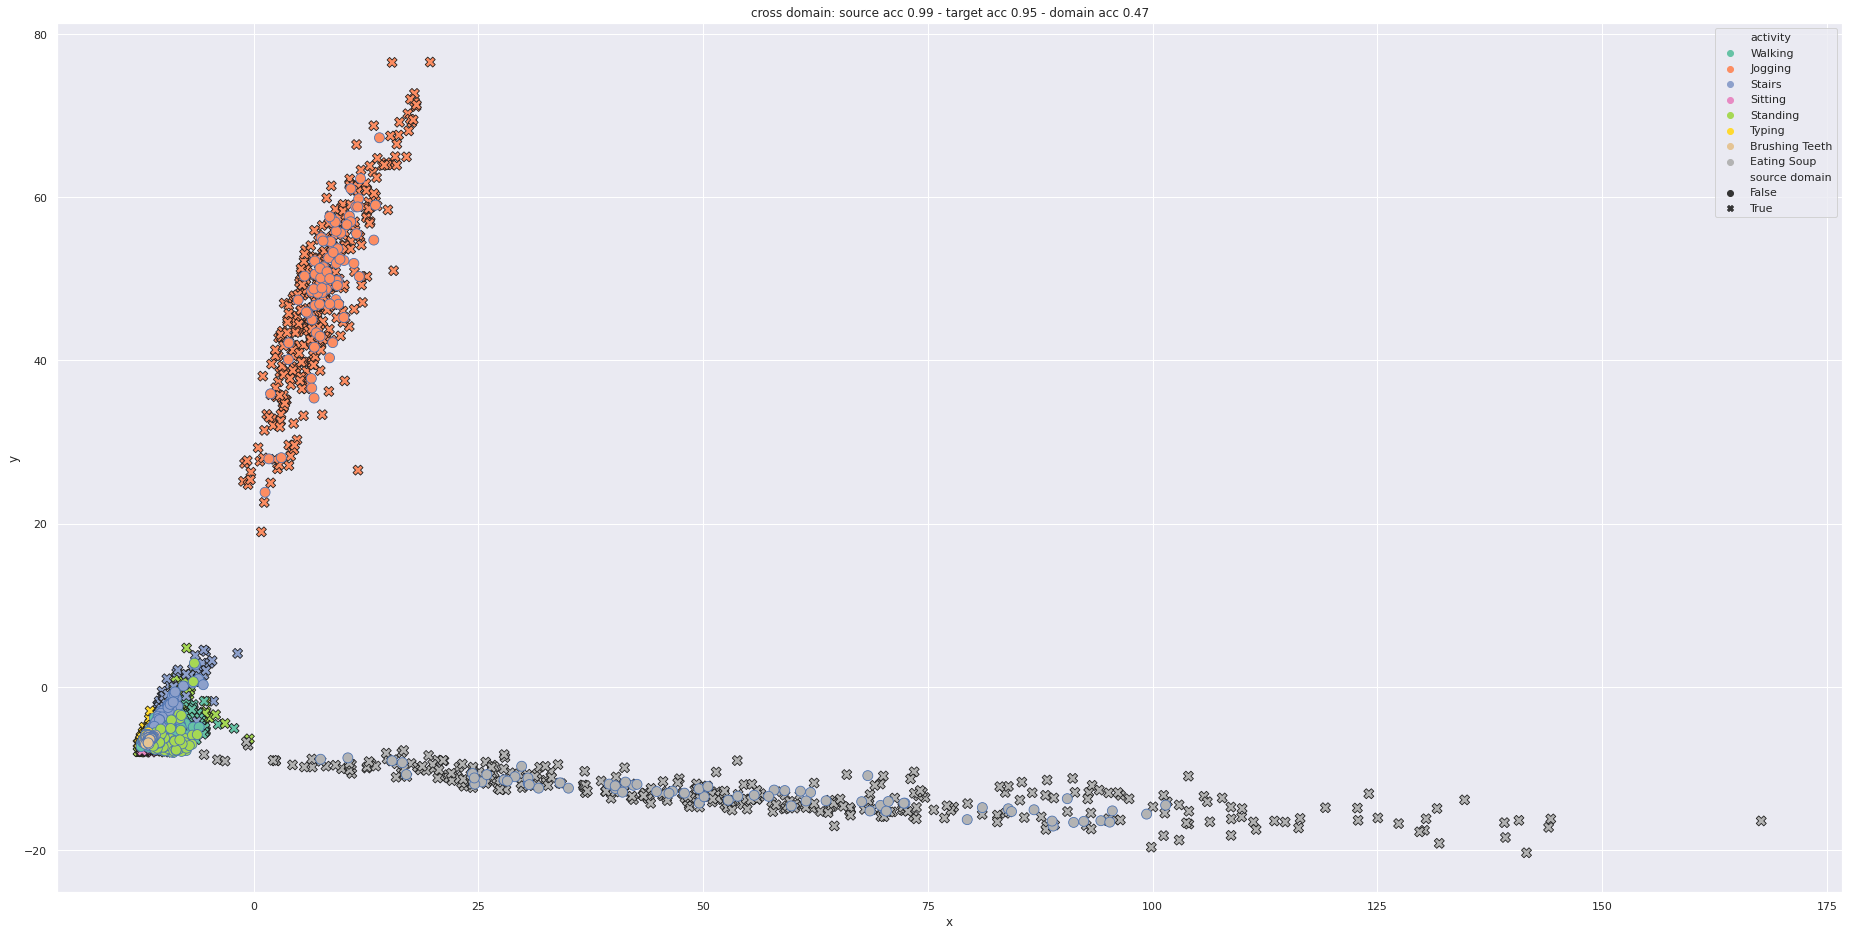

In [9]:
crossdomain_source_acc=[]
crossdomain_target_acc=[]

domain_label_acc=[]

for c in range(cv):
  tf.keras.backend.clear_session()
  crossdomain_model=dann.DANN(alpha=alpha,
                              epochs=EPOCHS,
                              batchsize=batchsize,
                              classifier_lr=clf_lr,
                              extractor_lr=ext_lr,
                              discriminator_lr=disc_lr)

  submodels=dann.submodel_config_march_15(num_class)
  crossdomain_model.set_submodels(submodels)

  crossdomain_model.cross_domain_train(seen_x,seen_y,unseen_x)

  source_acc=crossdomain_model.evaluate_classifier_acc(seen_x,seen_y)
  target_acc=crossdomain_model.evaluate_classifier_acc(unseen_x,unseen_y)
  domain_acc=crossdomain_model.evaluate_domain_acc(seen_x,unseen_x)

  print("============================ cv {}/{} ==========================".format(c+1,cv))
  print(source_acc)
  print(target_acc)
  print(domain_acc)
  print("==============================================================")

  crossdomain_source_acc.append(source_acc)
  crossdomain_target_acc.append(target_acc)
  domain_label_acc.append(domain_acc)

  dann.plot_pca_distributions(crossdomain_model.extractor,seen_x,seen_y,unseen_x,unseen_y,remapped_int_act_lookup)
  plt.title("cross domain: source acc {} - target acc {} - domain acc {}".format(np.round(source_acc,2),np.round(target_acc,2),np.round(domain_acc,2)))
  plt.legend(loc='upper right')

  plotname="crossdomain-{}_{}.jpg".format(c+1,cv)
  plotname=os.path.join(save_dir,plotname)

  plt.savefig(plotname,dpi=150,bbox_inches='tight')
  print(plotname)

summary['crossdomain source acc']=crossdomain_source_acc
summary['crossdomain target acc']=crossdomain_target_acc
summary['crossdomain domain acc']=domain_label_acc

In [10]:
print("source domain acc: ",crossdomain_source_acc)
print("avg: ",np.mean(crossdomain_source_acc))
print()
print("target domain acc: ",crossdomain_target_acc)
print("avg: ",np.mean(crossdomain_target_acc))

source domain acc:  [1.0, 0.9964788732394366, 0.9890845070422535, 0.9855633802816901, 0.9926056338028169]
avg:  0.9927464788732394

target domain acc:  [0.9190140845070423, 0.8838028169014085, 0.9348591549295775, 0.8679577464788732, 0.9454225352112676]
avg:  0.9102112676056338


In [11]:
summary

{'act': {0: 'Walking',
  1: 'Jogging',
  2: 'Stairs',
  3: 'Sitting',
  4: 'Standing',
  5: 'Typing',
  6: 'Brushing Teeth',
  7: 'Eating Soup'},
 'alpha': 0.75,
 'batchsize': 32,
 'clf lr': 0.0001,
 'crossdomain domain acc': [0.5741392801251957,
  0.452660406885759,
  0.4968701095461659,
  0.6474960876369327,
  0.46557120500782473],
 'crossdomain epoch': 90,
 'crossdomain source acc': [1.0,
  0.9964788732394366,
  0.9890845070422535,
  0.9855633802816901,
  0.9926056338028169],
 'crossdomain target acc': [0.9190140845070423,
  0.8838028169014085,
  0.9348591549295775,
  0.8679577464788732,
  0.9454225352112676],
 'disc lr': 0.0001,
 'ext lr': 0.0001,
 'indomain epoch': 20,
 'source class dist': {0: 355,
  1: 355,
  2: 355,
  3: 355,
  4: 355,
  5: 355,
  6: 355,
  7: 355},
 'source data shape': (2840, 100, 3),
 'source device': 'watch',
 'source sensor': 'accel',
 'source subj': [1600, 1601, 1602, 1603, 1604],
 'target class dist': {0: 71, 1: 71, 2: 71, 3: 71, 4: 71, 5: 71, 6: 71, 7: 

In [12]:
indomain_source_acc=[]
indomain_target_acc=[]
indomain_label_acc=[]

for c in range(cv):
  indomain_model=dann.DANN(alpha=alpha,
                           epochs=indomain_epoch,
                           batchsize=batchsize,
                           classifier_lr=clf_lr,
                           extractor_lr=ext_lr,
                           discriminator_lr=disc_lr)
  
  submodels=dann.submodel_config_march_15(num_class)
  indomain_model.set_submodels(submodels)

  indomain_model.source_domain_train(seen_x,seen_y)

  source_acc=indomain_model.evaluate_classifier_acc(seen_x,seen_y)
  target_acc=indomain_model.evaluate_classifier_acc(unseen_x,unseen_y)
  domain_acc=indomain_model.evaluate_domain_acc(seen_x,unseen_x)
  print("============================ cv {}/{} ==========================".format(c+1,cv))
  print(source_acc)
  print(target_acc)
  print(domain_acc)
  print("==============================================================")

  indomain_source_acc.append(source_acc)
  indomain_target_acc.append(target_acc)
  indomain_label_acc.append(domain_acc)

  dann.plot_pca_distributions(indomain_model.extractor,seen_x,seen_y,unseen_x,unseen_y,remapped_int_act_lookup)
  plt.title("source domain only: source acc {} - target acc {} - domain acc {}".format(np.round(source_acc,2),np.round(target_acc,2),np.round(domain_acc,2)))
  plt.legend(loc='upper right')

  plotname="indomain-{}_{}.jpg".format(c+1,cv)
  plotname=os.path.join(save_dir,plotname)

  plt.savefig(plotname,dpi=150,bbox_inches='tight')
  print(plotname)  

  summary['indomain source acc']=indomain_source_acc
  summary['indomain target acc']=indomain_target_acc
  summary['indomain domain acc']=indomain_label_acc

Output hidden; open in https://colab.research.google.com to view.

In [13]:
print("source domain acc: ",indomain_source_acc)
print("avg: ",np.mean(indomain_source_acc))
print()
print("target domain acc: ",indomain_target_acc)
print("avg: ",np.mean(indomain_target_acc))

source domain acc:  [0.9257042253521127, 1.0, 1.0, 0.9838028169014085, 0.9982394366197183]
avg:  0.9815492957746479

target domain acc:  [0.7359154929577465, 0.8045774647887324, 0.7940140845070423, 0.7059859154929577, 0.829225352112676]
avg:  0.773943661971831


In [14]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S %m/%d")

summary['timestamp']=current_time

In [15]:
summary

{'act': {0: 'Walking',
  1: 'Jogging',
  2: 'Stairs',
  3: 'Sitting',
  4: 'Standing',
  5: 'Typing',
  6: 'Brushing Teeth',
  7: 'Eating Soup'},
 'alpha': 0.75,
 'batchsize': 32,
 'clf lr': 0.0001,
 'crossdomain domain acc': [0.5741392801251957,
  0.452660406885759,
  0.4968701095461659,
  0.6474960876369327,
  0.46557120500782473],
 'crossdomain epoch': 90,
 'crossdomain source acc': [1.0,
  0.9964788732394366,
  0.9890845070422535,
  0.9855633802816901,
  0.9926056338028169],
 'crossdomain target acc': [0.9190140845070423,
  0.8838028169014085,
  0.9348591549295775,
  0.8679577464788732,
  0.9454225352112676],
 'disc lr': 0.0001,
 'ext lr': 0.0001,
 'indomain domain acc': [0.6265649452269171,
  0.4593114241001565,
  0.797926447574335,
  0.65160406885759,
  0.7713223787167449],
 'indomain epoch': 20,
 'indomain source acc': [0.9257042253521127,
  1.0,
  1.0,
  0.9838028169014085,
  0.9982394366197183],
 'indomain target acc': [0.7359154929577465,
  0.8045774647887324,
  0.79401408450

In [16]:
summary_savepath=os.path.join(save_dir,'summary.json')
with open (summary_savepath,'w') as jfile:
  json.dump(summary,jfile)